<a href="https://colab.research.google.com/github/Kushagratandon12/Machine-Learning-Projects/blob/master/Chest_X_Ray_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install kaggle
import os
import zipfile
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# local_zip = '/content/chest-xray-pneumonia.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

In [ ]:
# ! rm -rf /content/chest_xray/__MACOSX
# ! rm -rf /content/chest_xray/chest_xray

In [ ]:
img_dir= '/content/chest_xray'
traindf_normal = [os.path.join('/content/chest_xray/train/NORMAL',x) for x in 
                  os.listdir('/content/chest_xray/train/NORMAL')]
                  
traindf_pnenumia = [os.path.join('/content/chest_xray/train/PNEUMONIA',x) for x 
                    in os.listdir('/content/chest_xray/train/PNEUMONIA')]

testdf_normal = [os.path.join('/content/chest_xray/test/NORMAL',x) for x in 
                                     os.listdir('/content/chest_xray/test/NORMAL')]

testdf_pnenumia = [os.path.join('/content/chest_xray/test/PNEUMONIA',x) for x in 
                                               os.listdir('/content/chest_xray/test/PNEUMONIA')]

print(len(os.listdir('/content/chest_xray/train/NORMAL')))
print(len(os.listdir('/content/chest_xray/train/PNEUMONIA')))

1341
3875


## Data Visualization

Display Random Images


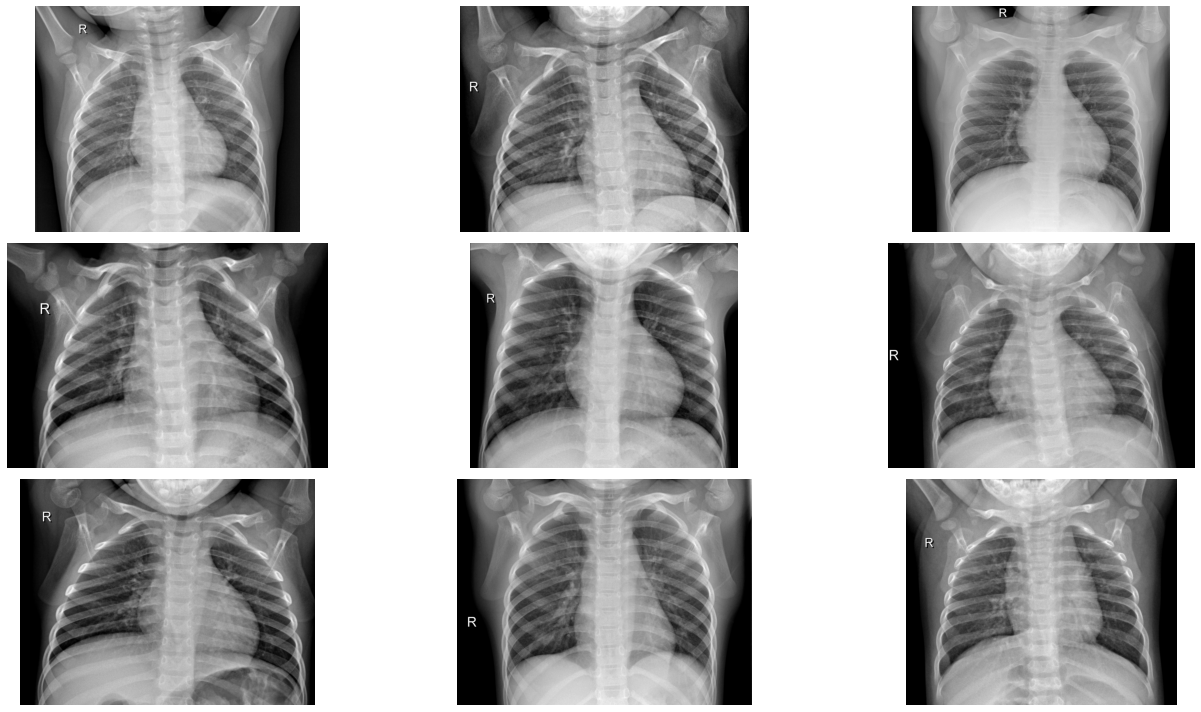

In [ ]:
# Extract 9 random images from it
random_images = [np.random.choice(traindf_normal) for i in range(9)]

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

IMAGE DATA GENERATOR

In [ ]:
TRAINING_DIR='/content/chest_xray/train'
train_datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        )

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    shuffle=True,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

VALIDATION_DIR='/content/chest_xray/test'
validation_datagen = ImageDataGenerator( rescale = 1.0/255.)
validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**BALANCING THE DATASET SINCE PNEUMONIA & NORMAL**

In [ ]:
from sklearn.utils import class_weight
classweights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.labels),
                                                 train_generator.labels)
print(classweights)
classweight = {0: classweights[0], 1: classweights[1]}
print('Weight for class 0: {:.2f}'.format(classweights[0]))
print('Weight for class 1: {:.2f}'.format(classweights[1]))

[1.9448173  0.67303226]
Weight for class 0: 1.94
Weight for class 1: 0.67


BUILDING THE MODEL

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3),include_top = True,weights='imagenet')

for layer in pre_trained_model.layers:
  layers.trainable = True

pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024 , activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1,activation='sigmoid')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.summary()

last layer output shape:  (None, 7, 7, 1280)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________

In [ ]:
# from keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
# callbacks_list = [checkpoint],[learning_rate_reduction]

# history=model.fit(train_generator,
#                   epochs=50,
#                   batch_size=100,
#                   verbose=1,
#                   shuffle=True,
#                   class_weight = classweight,
#                   validation_data=validation_generator,
#                   callbacks=callbacks_list
#                   )

from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
EPOCHS = 30
BATCH_SIZE = 204

Model_name = 'Inception_V3'+'_pretrained_model.h5'
checkpoint = ModelCheckpoint(Model_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping,checkpoint,learning_rate_reduction],
    # The class weights go here
    class_weight=classweight) 

Epoch 1/30
163/163 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.9329
Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to Inception_V3_pretrained_model.h5
163/163 [==============================] - 123s 752ms/step - loss: 0.4319 - accuracy: 0.9329 - val_loss: 34.5393 - val_accuracy: 0.6250
Epoch 2/30
163/163 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9615
Epoch 00002: val_accuracy did not improve from 0.62500
163/163 [==============================] - 119s 730ms/step - loss: 0.1487 - accuracy: 0.9615 - val_loss: 25.6383 - val_accuracy: 0.6250
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9670
Epoch 00003: val_accuracy did not improve from 0.62500

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
163/163 [==============================] - 118s 726ms/step - loss: 0.1015 - accuracy: 0.9670 - val_loss: 18.9488 - val_accuracy: 0.6250
Epoch 

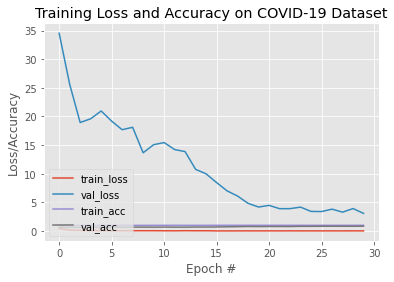

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

# plot the training loss and accuracy
N = len(history.history['accuracy'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [ ]:
from keras.models import load_model
saved_model = load_model('/content/Inception_V3_pretrained_model.h5')

In [ ]:
predictions = saved_model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import itertools
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      1.00      0.55       234
           1       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
